In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import regionate
import matplotlib.pyplot as plt

import warnings
import xbudget
import xwmt
import xwmb

## 0. Loading and preprocessing OM4 output into `xgcm.Grid` object

In [88]:
from example_dataset_grids import load_OM4p5
grid = load_OM4p5(z_coord="rho2")
ds = grid._ds

## 1. Determine a mask for the region of interest.

Here, we are interested in water masses on the Antarctic Shelf, which we define as shallower than 1000m. (However, because this is a global model and we don't want our model to include *all* shelves, we add a latitude-dependent mask.

In [89]:
ds['mask'] = (
    (ds['deptho'] <= 1000.) &
    (ds['geolat'] <= -57.5)
)

(0.0, 120.0)

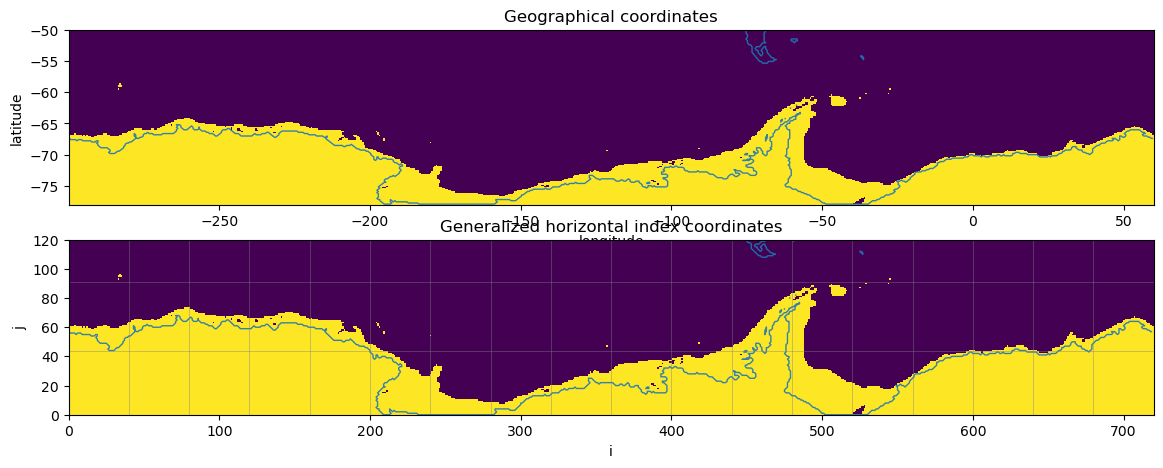

In [120]:
plt.figure(figsize=(14, 5))
plt.subplot(2,1,1)
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    ds.mask,
    vmin=0.2, vmax=1.
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
plt.title("Geographical coordinates")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.ylim(-78, -50)

plt.subplot(2,1,2)
plt.pcolor(
    ds.mask
)
plt.contour(
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
dlon=20.
plt.contour(
    ds['geolon_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-300., 60.+dlon, dlon)
)

dlat = 10.
plt.contour(
    ds['geolat_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-90., 90.+dlat, dlat)
);
plt.title("Generalized horizontal index coordinates")
plt.xlabel("i")
plt.ylabel("j");
plt.ylim(0, 120)

## 2. We use `regionate` to find the sections that bound the region

On the backend, this approach uses `countourpy` to find the decimal indices of the contours of the mask in index space, and then convert these into the corresponding integer indices of the ocean model's vorticity grid (corners of C-grid tracer cells). 

In [90]:
from regionate import MaskRegions, GriddedRegion
regions = MaskRegions(ds.mask, grid).regions

## 3. We pick out the particular contour we want to focus on

Since our specified mask is actually made up of many distinct contiguous masks, `regionate` seperates them all out and returns a dictionary (with numbered labels that go from longest to shortest perimeter). Since the Antarctic shelf is obviously the longest contour of our bunch, we can just pick the `0` index and ignore all of the smaller seaward islands/rises and shoreward depressions.

In [91]:
antarctic = regions[0]
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

(0.0, 120.0)

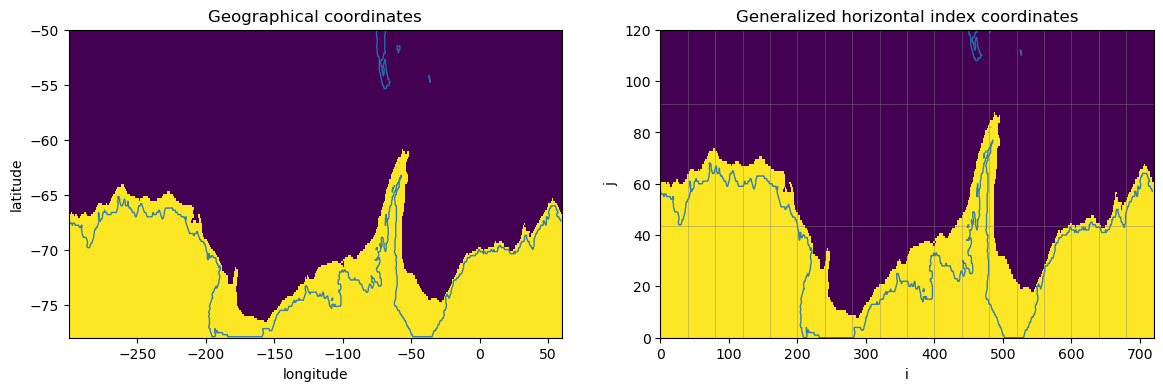

In [121]:
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    region.mask,
    vmin=0.2, vmax=1.
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
plt.title("Geographical coordinates")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.ylim(-78, -50)

plt.subplot(1,2,2)
plt.pcolor(
    region.mask
)
plt.contour(
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
dlon=20.
plt.contour(
    ds['geolon_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-300., 60.+dlon, dlon)
)

dlat = 10.
plt.contour(
    ds['geolat_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-90., 90.+dlat, dlat)
);
plt.title("Generalized horizontal index coordinates")
plt.xlabel("i")
plt.ylabel("j");
plt.ylim(0, 120)

### 4. Organize mass budget terms (from mass, heat, and salt budgets)

In [93]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)

### 5. Compute the water mass budget in potential density coordinates

In [94]:
wmb = xwmb.WaterMassBudget(
    grid,
    budgets_dict,
    region
)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb.mass_budget(
        "sigma2", # target sigma2 coordinate
        default_bins=True, # default 0.1 kg/m^3 density bin spacing
        along_section=True # compute the overturning term by directly evaluating the surface integral
    )

In [101]:
wmt = xr.Dataset()
wmt["convergent_mass_transport_along"] = wmb.grid._ds.convergent_mass_transport_along.mean("time").compute()

# Key water mass transformation budget terms
wmt['Eulerian_tendency'] = wmb.wmt['Eulerian_tendency'].mean("time").compute()
wmt['advection'] = wmb.wmt['advection'].mean("time").compute()
wmt['diffusion'] = wmb.wmt['diffusion'].mean("time").compute()
wmt['boundary_fluxes'] = wmb.wmt['boundary_fluxes'].mean("time").compute()
wmt['convergent_mass_transport'] = wmb.wmt['convergent_mass_transport'].mean("time").compute();
wmt['mass_tendency'] = wmb.wmt['mass_tendency'].mean("time").compute();
wmt['mass_source'] = wmb.wmt['mass_source'].mean("time").compute();
wmt['spurious_numerical_mixing'] = wmb.wmt['spurious_numerical_mixing'].mean("time").compute();

(34.0, 38.0)

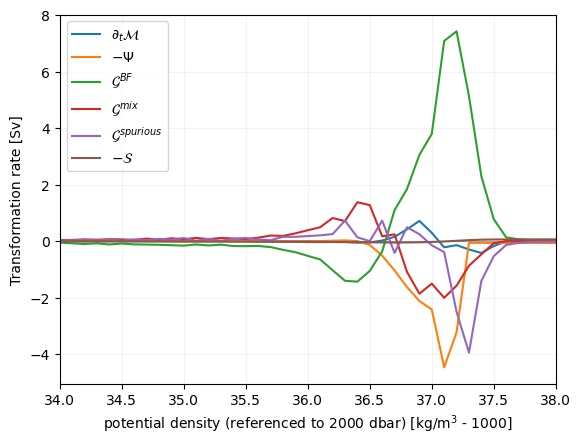

In [109]:
toSv = 1e-6/1035.

plt.axhline(0., color="k", alpha=0.3, lw=0.8)

(wmt['mass_tendency']*toSv).plot(label=r"$\partial_{t} \mathcal{M}$", color="C0")
(-wmt['convergent_mass_transport']*toSv).plot(label=r"$-\Psi$", color="C1")
(wmt['boundary_fluxes']*toSv).plot(label=r"$\mathcal{G}^{BF}$", color="C2")
(wmt['diffusion']*toSv).plot(label=r"$\mathcal{G}^{mix}$", color="C3")
(wmt['spurious_numerical_mixing']*toSv).plot(label=r"$\mathcal{G}^{spurious}$", color="C4")
(-wmt['mass_source']*toSv).plot(label=r"$-\mathcal{S}$", color="C5")

plt.legend()
plt.grid(True, alpha=0.15)
plt.ylabel("Transformation rate [Sv]")
plt.xlabel(r"potential density (referenced to 2000 dbar) [kg/m$^3$ - 1000]");
plt.xlim(34, 38)

(38.0, 36.0)

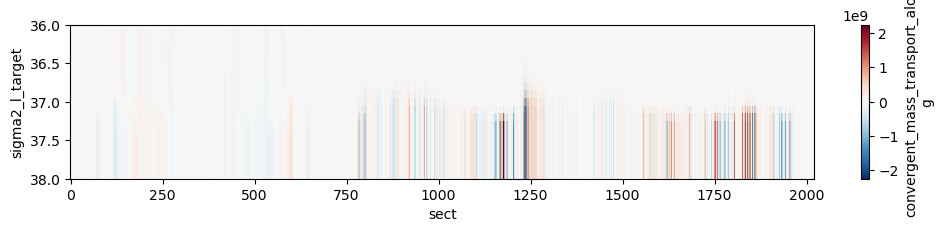

In [113]:
plt.figure(figsize=(12, 2))
wmt['convergent_mass_transport_along'].plot(x="sect")
plt.ylim(38, 36)

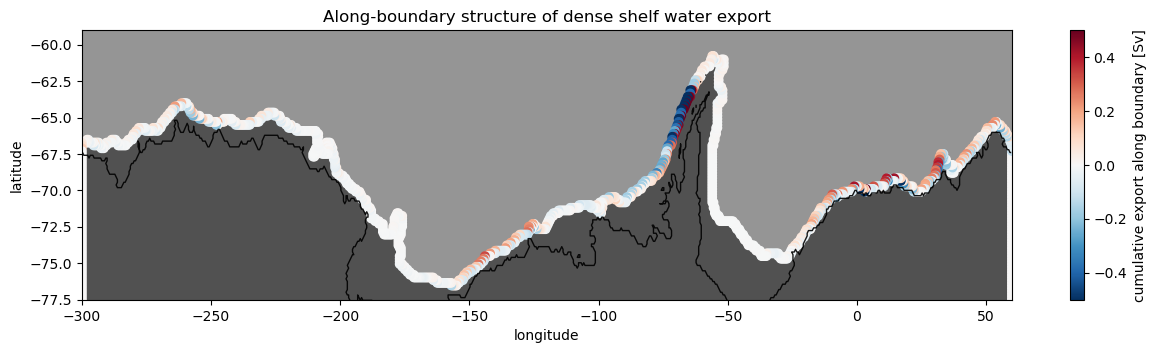

In [119]:
outflows = -wmt['convergent_mass_transport_along'].sel(sigma2_l_target=37.0, method="nearest")*toSv

plt.figure(figsize=(15, 3.5))
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    region.mask,
    vmin=-2, vmax=2,
    cmap="Greys"
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="k",
    linewidths=1.,
    alpha=0.9
)
sc = plt.scatter(
    wmb.region.lons,
    wmb.region.lats,
    c=outflows,
    cmap="RdBu_r"
)
plt.colorbar(sc, label="cumulative export along boundary [Sv]")
plt.title("Along-boundary structure of dense shelf water export")
plt.clim(-0.5, 0.5)
plt.xlim(-300, 60)
plt.ylim(-77.5, -59);
plt.xlabel("longitude")
plt.ylabel("latitude");